In [1]:
import re 
import pandas as pd 
from time import time 
from collections import defaultdict 
import spacy
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [2]:
!python -m spacy download en

     ---------------------------------------- 13.9/13.9 MB 7.8 MB/s eta 0:00:00
[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
# IMPORT DATA WITH GOOGLE COLAB AND GOOGLE SHEETS

# from google.colab import auth
# auth.authenticate_user()
# import gspread
# from oauth2client.client import GoogleCredentials

# # setup
# gc = gspread.authorize(GoogleCredentials.get_application_default())

# # read data and put it in a dataframe
# gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/1AwqUNB68gx-KSlfYSib4RMGOEeHAViuElRsUFoA1cNA/edit?usp=sharing')
# sheets = gsheets.worksheet('All').get_all_values()
# raw_df = pd.DataFrame(sheets[1:], columns=sheets[0])
# raw_df

In [4]:
raw_df = pd.read_excel(open('data.xlsx', 'rb'),
              sheet_name='All', ).fillna('') 
raw_df

,Dog,Elephant,Snake,Pig,Cow,Fish,Cat,Steak,Kebab,Pork,...,Plane,Skateboard,Helicopter,Bicycle,Computer,Keyboard,Monitor,CPU,TV,Phone
0,Does a dog have ears?,The appearance of the Asiatic elephant is fami...,There could be a snake in the daylight.,"If I promise not to act like a misogynist pig,...","The Latin word for ""cow"" is vacca.",The fish flipped and dived back into the water.,I think the cat wants dessert!,That's a long way to drive for steak and potat...,"The insane person, who will actually eat a kebab.","Your pork chops were a big hit, by the way.",...,I'll make a plane reservation.,It is a small park with a skateboard area.,We've got a helicopter on the way.,The boy no doubt inherits a capacity for ridin...,A computer can do some tasks better than a per...,"She began to paw at her computer keyboard, sea...","As he lifted the computer monitor, he caught s...","This year, Sony is seeking to top themselves w...",It's as safe as watching TV and a darned sight...,"The phone woke me up, even though it wasn't ve..."
1,Then let's have a seat and watch the puppy dog...,"Further, the skin is stated to be much less ro...","A mouse she could handle – literally, but a sn...","Oh, what a pig I am! he repeated, flushing sud...",Can't you eat a cow or a rabbit or something?,I ate very small fish for supper.,I'm in no mood to watch a cat fight tonight.,They each ordered a salad and steak and attack...,"You haven't had a dodgy doner kebab, have you?",The city is a manufacturing and railway centre...,...,I'm still not going to watch your plane leave.,Finding the right skateboard can sound like qu...,The helicopter dropped and caught.,He ran out to his bicycle and pushed the kicks...,I haven't been near a computer since before I ...,The keyboard has five keys similar to those of...,It's my responsibility to monitor and deter th...,And uses almost ALL CPU to actually log in.,The only thing you watch on TV is football and...,Is he listening to your phone call?
2,My dog scared them away.,The Indian region is the home of the Indian el...,"If there is a snake under it, that puts a rock...","He couldn't very well say, 'I really am that p...",Although the technique of growing cowpox on co...,"You can be a cold fish, sometimes.",The cat would like to eat the mouse.,He forked a steak off the serving tray and han...,I followed with Fish kebab (£ 10.95) - a bumpe...,"It is known for its pork pies, and has a trade...",...,The only thing left to do was pack and take a ...,"I'm 33, female, I skateboard a little, have do...",The helicopter lifted away before Brady had tw...,The only thing you watch on TV is football and...,Her phone and computer are monitored.,Each channel consists of a keyboard and receiv...,He turned away from the monitor and searched h...,We replaced the CPU soak tested for 48 hours a...,Let's go watch TV in the family room.,Martha handed her the phone and I could tell b...
3,"He held out his hand for the dog to sniff, but...",South of the Thames the thoroughfares crossing...,"In tropical waters a sea snake is found, which...","In 2006, a pig was genetically engineered to p...","Of animals, the cow and the pig are her favour...",Did you ever hunt or fish with your father?,A large grey cat was asleep on a rocking chair.,Says the veterinarian who envisioned steak lin...,They provide nothing for the serious kebab con...,Swine and pork are largely exported to Russia ...,...,"All right, I'll charter a plane for the morning.",Since 1999 we have been the UK 's premier onli...,She saw smoke moving across the sky a moment b...,"He wore bathing trunks, a Phillies baseball ca...","The computer screen before him was blank, but ...","Rita Angeltoni banged away on her keyboard, co...","After two hours' fighting, the ""Monitor"" was d...","The greater the number, the less CPU the proce...","I did TV too, a McDonald's commercial.",The phone woke me.
4,This dog helped him watch the sheep.,Mahmud ordered Hasan Maimandi to take the poet...,What if a

In [5]:
df = pd.DataFrame({'raw_character_text' : [], 'spoken_words': []})
df

,raw_character_text,spoken_words


In [6]:
for column in raw_df.columns:
  for value in raw_df[column]:
    if value:
      df = pd.concat([df, pd.DataFrame({'raw_character_text': [column], 'spoken_words': [value]})], ignore_index=True)

df

,raw_character_text,spoken_words
0,Dog,Does a dog have ears?
1,Dog,Then let's have a seat and watch the puppy dog...
2,Dog,My dog scared them away.
3,Dog,"He held out his hand for the dog to sniff, but..."
4,Dog,This dog helped him watch the sheep.
...,...,...
6066,Phone,It was an independent lab and when Cynthia too...
6067,Phone,"Before leaving the Beaumont, he looked at the ..."
6068,Phone,"The phone rang, precluding a pithy rejoinder, ..."
6069,Phone,Dean handed the phone to his wife as the light...


In [7]:
df['raw_character_text'].value_counts()

Car           385
Fish          340
Keyboard      329
Dog           326
Computer      324
Cow           292
Monitor       292
Phone         286
Snake         257
TV            256
Bike          254
Tomato        253
Steak         252
Pig           251
Motorcycle    248
Salad         232
Plane         228
Pork          213
Cat           212
Bicycle       191
Onion         181
Elephant      168
Helicopter    166
CPU            68
Skateboard     50
Kebab          17
Name: raw_character_text, dtype: int64

In [8]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop and (len(token) > 2 or str(token).lower() == 'tv')]

    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.26 mins


In [9]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(5817, 1)

In [10]:
df_clean

,clean
1,let seat watch puppy dog parade
2,dog scare away
3,hold hand dog sniff nikolai nuzzle nose instead
4,dog help watch sheep
5,poor owner crumpled van sob accordioned quarte...
...,...
6066,independent lab cynthia take bathroom break fr...
6067,leave beaumont look recently publish ouray pho...
6068,phone rang preclude pithy rejoinder cynthia el...
6069,dean hand phone wife light go like comic book ...


In [11]:
from gensim.models.phrases import Phrases, Phraser

sent = [row.split() for row in df_clean['clean']]

phrases = Phrases(sent, min_count=5, progress_per=100)

bigram = Phraser(phrases)

sentences = bigram[sent]

INFO - 16:14:48: collecting all words and their counts
INFO - 16:14:48: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 16:14:48: PROGRESS: at sentence #100, processed 1340 words and 2095 word types
INFO - 16:14:48: PROGRESS: at sentence #200, processed 2738 words and 4002 word types
INFO - 16:14:48: PROGRESS: at sentence #300, processed 3595 words and 5027 word types
INFO - 16:14:48: PROGRESS: at sentence #400, processed 4868 words and 6620 word types
INFO - 16:14:48: PROGRESS: at sentence #500, processed 6264 words and 8192 word types
INFO - 16:14:48: PROGRESS: at sentence #600, processed 7449 words and 9627 word types
INFO - 16:14:48: PROGRESS: at sentence #700, processed 8478 words and 10813 word types
INFO - 16:14:48: PROGRESS: at sentence #800, processed 9991 words and 12498 word types
INFO - 16:14:48: PROGRESS: at sentence #900, processed 11108 words and 13742 word types
INFO - 16:14:48: PROGRESS: at sentence #1000, processed 12146 words and 14917 word types


In [12]:
sentences[0]

['let', 'seat', 'watch', 'puppy', 'dog', 'parade']

In [13]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

11732

In [14]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['fish',
 'car',
 'computer',
 'dog',
 'monitor',
 'snake',
 'bike',
 'keyboard',
 'steak',
 'cat']

In [15]:
import multiprocessing

from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

w2v_model = Word2Vec(min_count=8,
                     window=4,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

INFO - 16:14:48: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.03)', 'datetime': '2022-03-19T16:14:48.693753', 'gensim': '4.1.2', 'python': '3.10.3 (tags/v3.10.3:a342a49, Mar 16 2022, 13:07:40) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}


In [16]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 16:14:48: collecting all words and their counts
INFO - 16:14:48: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:14:48: collected 11732 word types from a corpus of 59253 raw words and 5817 sentences
INFO - 16:14:48: Creating a fresh vocabulary
INFO - 16:14:48: Word2Vec lifecycle event {'msg': 'effective_min_count=8 retains 1600 unique words (13.637913399249914%% of original 11732, drops 10132)', 'datetime': '2022-03-19T16:14:48.759569', 'gensim': '4.1.2', 'python': '3.10.3 (tags/v3.10.3:a342a49, Mar 16 2022, 13:07:40) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'prepare_vocab'}
INFO - 16:14:48: Word2Vec lifecycle event {'msg': 'effective_min_count=8 leaves 39507 word corpus (66.67510505797175%% of original 59253, drops 19746)', 'datetime': '2022-03-19T16:14:48.760569', 'gensim': '4.1.2', 'python': '3.10.3 (tags/v3.10.3:a342a49, Mar 16 2022, 13:07:40) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-S

Time to build vocab: 0.0 mins


In [17]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 16:14:48: Word2Vec lifecycle event {'msg': 'training model with 15 workers on 1600 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=4 shrink_windows=True', 'datetime': '2022-03-19T16:14:48.805677', 'gensim': '4.1.2', 'python': '3.10.3 (tags/v3.10.3:a342a49, Mar 16 2022, 13:07:40) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'train'}
INFO - 16:14:48: worker thread finished; awaiting finish of 14 more threads
INFO - 16:14:48: worker thread finished; awaiting finish of 13 more threads
INFO - 16:14:48: worker thread finished; awaiting finish of 12 more threads
INFO - 16:14:48: worker thread finished; awaiting finish of 11 more threads
INFO - 16:14:48: worker thread finished; awaiting finish of 10 more threads
INFO - 16:14:48: worker thread finished; awaiting finish of 9 more threads
INFO - 16:14:48: worker thread finished; awaiting finish of 8 more threads
INFO - 16:14:48: worker thread finished; awaiting finish of 7 mor

INFO - 16:14:49: worker thread finished; awaiting finish of 9 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 8 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 7 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 6 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 5 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 4 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 3 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 2 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 1 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 0 more threads
INFO - 16:14:49: EPOCH - 7 : training on 59253 raw words (14777 effective words) took 0.0s, 551788 effective words/s
INFO - 16:14:49: worker thread finished; awaiting finish of 14 more threads
INFO - 16:14:49: worker thread finished; awaiting finish 

INFO - 16:14:49: EPOCH - 13 : training on 59253 raw words (14772 effective words) took 0.1s, 278667 effective words/s
INFO - 16:14:49: worker thread finished; awaiting finish of 14 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 13 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 12 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 11 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 10 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 9 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 8 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 7 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 6 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 5 more threads
INFO - 16:14:49: worker thread finished; awaiting finish of 4 more threads
INFO - 16:14:49: worker thread finished; awaiting fi

INFO - 16:14:50: worker thread finished; awaiting finish of 6 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 5 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 4 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 3 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 2 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 1 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 0 more threads
INFO - 16:14:50: EPOCH - 20 : training on 59253 raw words (14881 effective words) took 0.1s, 251045 effective words/s
INFO - 16:14:50: worker thread finished; awaiting finish of 14 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 13 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 12 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 11 more threads
INFO - 16:14:50: worker thread finished; awaiting fin

INFO - 16:14:50: worker thread finished; awaiting finish of 13 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 12 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 11 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 10 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 9 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 8 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 7 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 6 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 5 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 4 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 3 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 2 more threads
INFO - 16:14:50: worker thread finished; awaiting finish of 1 more threads
INFO - 16:14:50: work

Time to train the model: 0.04 mins


In [18]:
w2v_model.init_sims(replace=True)

C:\Users\makso\AppData\Local\Temp\ipykernel_11700\514372312.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)
WARNING - 16:14:50: destructive init_sims(replace=True) deprecated & no longer required for space-efficiency


In [19]:
w2v_model.wv.most_similar(positive=["cat"],topn=15)

[('mouse', 0.9996837377548218),
 ('eastern', 0.9996473789215088),
 ('morning', 0.9996464848518372),
 ('shove', 0.9996443390846252),
 ('people', 0.9996426701545715),
 ('later', 0.9996423721313477),
 ('watch', 0.9996412992477417),
 ('modern', 0.9996403455734253),
 ('let', 0.9996374845504761),
 ('return', 0.9996345639228821),
 ('release', 0.9996342062950134),
 ('datum', 0.9996336698532104),
 ('corner', 0.9996333718299866),
 ('listen', 0.9996330738067627),
 ('train', 0.9996290802955627)]

In [20]:
w2v_model.wv.similarity("dog", 'cat')

0.99954903

In [21]:
w2v_model.wv.doesnt_match(['dog', 'cat', 'bike'])

'bike'

In [22]:
w2v_model.wv.most_similar(positive=["elephant", "monitor"], negative=["tv"], topn=3)

[('bear', 0.999104380607605),
 ('fox', 0.9990628361701965),
 ('african', 0.999050498008728)]

In [23]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

In [24]:
col_names = [x.lower() for x in df['raw_character_text'].unique()]

In [33]:
col_names

['dog',
 'elephant',
 'snake',
 'pig',
 'cow',
 'fish',
 'cat',
 'steak',
 'kebab',
 'pork',
 'salad',
 'tomato',
 'onion',
 'car',
 'motorcycle',
 'bike',
 'plane',
 'skateboard',
 'helicopter',
 'bicycle',
 'computer',
 'keyboard',
 'monitor',
 'cpu',
 'tv',
 'phone']

D:\dev\neural-semantic-embeddings\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\dev\neural-semantic-embeddings\venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


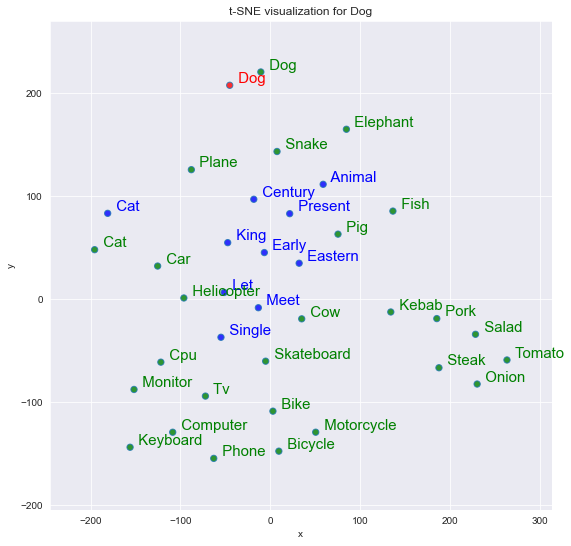

In [25]:
tsnescatterplot(w2v_model, 'dog', col_names)

D:\dev\neural-semantic-embeddings\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\dev\neural-semantic-embeddings\venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


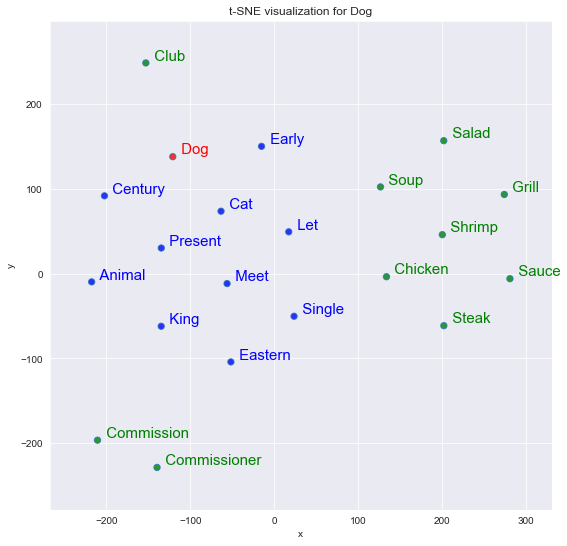

In [26]:
tsnescatterplot(w2v_model, 'dog', [i[0] for i in w2v_model.wv.most_similar(negative=["dog"])])

In [27]:
word_annotations = {
 'dog': 'animal',
 'elephant': 'animal',
 'snake': 'animal',
 'pig': 'animal',
 'cow': 'animal',
 'fish': 'animal',
 'cat': 'animal',
 'steak': 'meal',
 'kebab': 'meal',
 'pork': 'meal',
 'salad': 'meal',
 'tomato': 'meal',
 'onion': 'meal',
 'car': 'vehicle',
 'motorcycle': 'vehicle',
 'bike': 'vehicle',
 'plane': 'vehicle',
 'skateboard': 'vehicle',
 'helicopter': 'vehicle',
 'bicycle': 'vehicle',
 'computer': 'device',
 'keyboard': 'device',
 'monitor': 'device',
 'cpu': 'device',
 'tv': 'device',
 'phone': 'device',
}

D:\dev\neural-semantic-embeddings\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\dev\neural-semantic-embeddings\venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


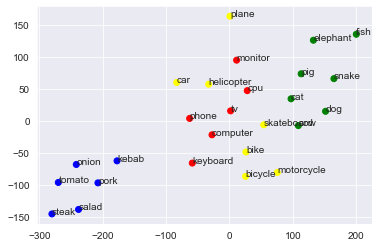

In [28]:
colors = {'animal':'green', 'meal':'blue', 'vehicle':'yellow', 'device':'red'}

X = []

for col in col_names:
  X.append(w2v_model.wv[col])

tsne = TSNE(n_components=2, n_iter=3000, random_state=np.random.RandomState(40), perplexity=10)
X_tsne = tsne.fit_transform(X)

c = [colors[word_annotations[x]] for x in col_names]

fig, ax = plt.subplots()
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=c)

for i, txt in enumerate(X):
    ax.annotate(col_names[i], (X_tsne[:, 0][i], X_tsne[:, 1][i]))

In [29]:
import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

INFO - 16:14:52: loading projection weights from C:\Users\makso/gensim-data\glove-wiki-gigaword-300\glove-wiki-gigaword-300.gz


['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


INFO - 16:15:41: KeyedVectors lifecycle event {'msg': 'loaded (400000, 300) matrix of type float32 from C:\\Users\\makso/gensim-data\\glove-wiki-gigaword-300\\glove-wiki-gigaword-300.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-03-19T16:15:41.403153', 'gensim': '4.1.2', 'python': '3.10.3 (tags/v3.10.3:a342a49, Mar 16 2022, 13:07:40) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'load_word2vec_format'}


In [30]:
glove_vectors.most_similar('dog')

[('dogs', 0.7888556718826294),
 ('cat', 0.6816747188568115),
 ('pet', 0.6291599273681641),
 ('puppy', 0.5936061143875122),
 ('hound', 0.5468214154243469),
 ('horse', 0.5369751453399658),
 ('animal', 0.5316445827484131),
 ('cats', 0.5080744028091431),
 ('canine', 0.5038436055183411),
 ('pets', 0.5019966959953308)]

D:\dev\neural-semantic-embeddings\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\dev\neural-semantic-embeddings\venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


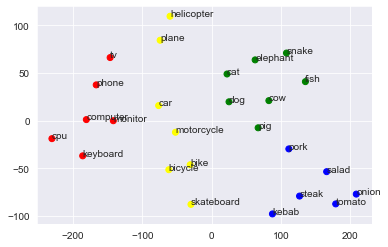

In [31]:
X = []

for col in col_names:
  X.append(glove_vectors[col])

tsne = TSNE(n_components=2, n_iter=3000, random_state=np.random.RandomState(20), perplexity=10)
X_tsne = tsne.fit_transform(X)

c = [colors[word_annotations[x]] for x in col_names]

fig, ax = plt.subplots()
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=c)

for i, txt in enumerate(X):
    ax.annotate(col_names[i], (X_tsne[:, 0][i], X_tsne[:, 1][i]))

In [32]:
glove_vectors.most_similar(positive=["woman", "king"], negative=["queen"], topn=3)

[('man', 0.6788583993911743),
 ('father', 0.5293230414390564),
 ('person', 0.5283361673355103)]